# 7-1 여러 개의 이미지를 분류하는 다층 신경망

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
class MultiClassNetwork:
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0) -> None:
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m

        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)

        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def softmax(slef, z):
        z = np.clip(z, -100, None)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

    def init_weight(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weight(x.shape[1], y.shape[1])

        for i in range(epochs):
            loss = 0

            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)

                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += np.sum(-y_batch*np.log(a))

            self.losses.append((loss + self.reg_loss()) / len(x))

            self.update_val_loss(x_val, y_val)

            print(f'epoch: {i+1} / {epochs}')

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]

    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.softmax(z)
        err = -(y - a)

        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)

        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

        self.w1 -= self.lr * w1_grad
        self.w2 -= self.lr * w2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)

    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)

        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))


In [5]:
import tensorflow as tf
tf.__version__

'2.6.1'

In [6]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


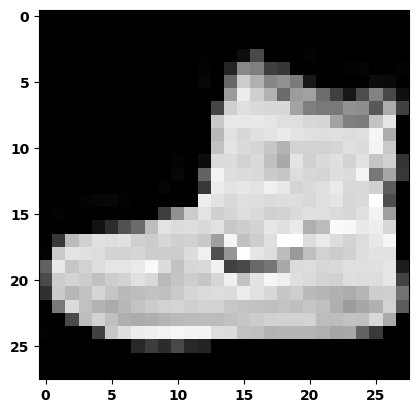

In [8]:
plt.imshow(x_train_all[0], cmap='gray')


In [10]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', 
               '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [11]:
print(class_names[y_train_all[0]])

앵클부츠


In [12]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
    stratify=y_train_all, test_size=0.2, random_state=42)


In [16]:
print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [17]:
# 정규화 하기
x_train = x_train / 255
x_val = x_val / 255

In [18]:
# 훈련세트, 검증세트 차원 변경(flatten)
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [19]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [20]:
# 타깃 원-핫 인코딩 변환
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [23]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [35]:
# MultiClassNetwork 클래스로 다중 분류 신경망 훈련
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

epoch: 1 / 40
epoch: 2 / 40
epoch: 3 / 40
epoch: 4 / 40
epoch: 5 / 40
epoch: 6 / 40
epoch: 7 / 40
epoch: 8 / 40
epoch: 9 / 40
epoch: 10 / 40
epoch: 11 / 40
epoch: 12 / 40
epoch: 13 / 40
epoch: 14 / 40
epoch: 15 / 40
epoch: 16 / 40
epoch: 17 / 40
epoch: 18 / 40
epoch: 19 / 40
epoch: 20 / 40
epoch: 21 / 40
epoch: 22 / 40
epoch: 23 / 40
epoch: 24 / 40
epoch: 25 / 40
epoch: 26 / 40
epoch: 27 / 40
epoch: 28 / 40
epoch: 29 / 40
epoch: 30 / 40
epoch: 31 / 40
epoch: 32 / 40
epoch: 33 / 40
epoch: 34 / 40
epoch: 35 / 40
epoch: 36 / 40
epoch: 37 / 40
epoch: 38 / 40
epoch: 39 / 40
epoch: 40 / 40


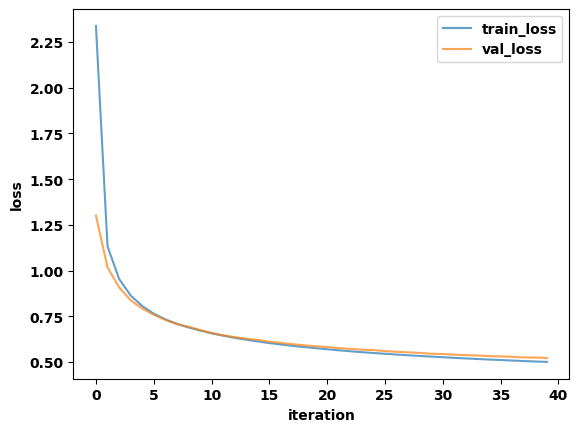

In [37]:
plt.plot(fc.losses, alpha=0.7)
plt.plot(fc.val_losses, alpha=0.7)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [39]:
fc.score(x_val, y_val_encoded)

0.81475

# 7-2 텐서플로와 케라스를 사용한 신경망

In [ ]:
# 훈련할 가중치 변수 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 옵티마이저
optimizer = tf.optimizers.SGD(lr = 0.01)

#에포크
num_epochs = 10
for step in range(num_epochs):

    # 자동 미분
    with tf.GradientTape() as tape:
        z_net = w * x_train + b
        z_net = tf.reshape(z_net, [-1])
        sqr_errors = tf.square(y_train - z_net)
        mean_cost = tf.reduce_mean(sqr_errors)
    
    grads = tape.gradient(mean_cost, [w, b])
    optimizer.apply_gradients(zip(grads, [w, b]))

In [42]:
# 위 신경망을 케라스로 구현
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='sgd', loss='mse')
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 4s 1ms/step - loss: nan
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 8/10
1500/1500 [==============================] - 2s 2ms/step - loss: nan
Epoch 9/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan
Epoch 10/10
1500/1500 [==============================] - 2s 1ms/step - loss: nan


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# Sequential 객체 층 추가 예시
# 1
model = Sequential([Dense(...), ...])
# 2
dense = Dense(...)
model.add(dense)
# 3
model = Sequential()
model.add(Dense(...))
model.add(Dense(...))

Dense 클래스 사용법
* unit: 뉴런의 개수 지정
* activation: ghkftjdghk gkatn wlwjd

Sequential 클래스의 compile 함수
* optimizer: 최적화 방법(경사 하강법, ...)
* loss: 손실 함수 지정(제곱 오차, 로지스틱, 크로스 엔트로피, ...)
  

Sequential 클래스
* fit(): 모델 훈련
* predict(): 에측
* evaluate(): 검증, 테스트 세트 평가 시

In [45]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [48]:
# 케라스로 다중 분류 신경망 만들기
model = Sequential()
# 은닉층, 출력층 추가
model.add(Dense(100, activation='sigmoid', input_shape=(784, )))
model.add(Dense(10, activation='softmax'))
# 최적화 알고리즘, 손실 함수 지정
# metrics 매개변수는 훈련하며 기록한 정보를 History 객체에 담아 반환해줌
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit(x_train, y_train_encoded, epochs=40,
    validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 1.3645 - accuracy: 0.6474 - val_loss: 0.9645 - val_accuracy: 0.7258
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8477 - accuracy: 0.7412 - val_loss: 0.7564 - val_accuracy: 0.7578
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7174 - accuracy: 0.7602 - val_loss: 0.6691 - val_accuracy: 0.7780
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6520 - accuracy: 0.7771 - val_loss: 0.6169 - val_accuracy: 0.7880
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6093 - accuracy: 0.7895 - val_loss: 0.5806 - val_accuracy: 0.8011
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5783 - accuracy: 0.8005 - val_loss: 0.5557 - val_accuracy: 0.8074
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5547 - accuracy: 0.8087 - val_loss: 0.5334 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


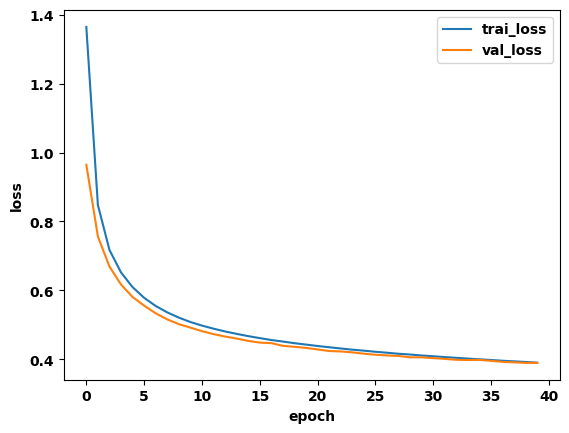

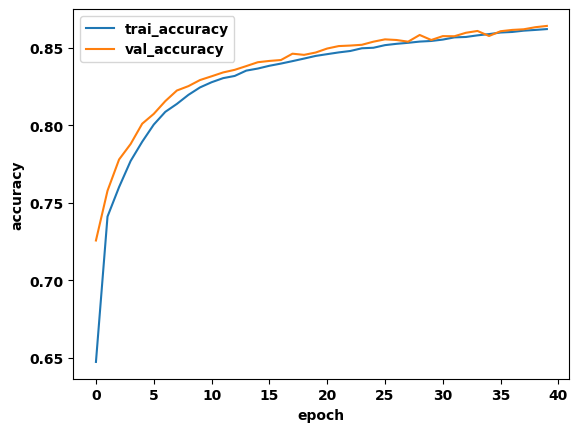

In [55]:
# 손실, 정확도 그래프 그리기
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trai_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['trai_accuracy', 'val_accuracy'])
plt.show()

In [56]:
# 검증 세트 정확도 계산
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8641666769981384
